# Import Dataset

Class `DIV2K` can help us download datasets from [official DIV2K dataset](https://data.vision.ee.ethz.ch/cvl/DIV2K/) and generate final dataset with data augmentation (including image crop, flip, and rotation). Besides generating dataset, it also caches images first to improve further I/O performance. This class is modified from the implementation of [krasserm](https://raw.githubusercontent.com/krasserm/super-resolution/master/data.py)

In [1]:
import os
import tensorflow as tf
import enum
from tensorflow.python.data.experimental import AUTOTUNE

base_dir = './'

class DIV2KDATA(enum.Enum):
  DIV2K_train_LR_x8 = 'DIV2K_train_LR_x8'
  DIV2K_train_LR_bicubic_X2 = 'DIV2K_train_LR_bicubic_X2'
  DIV2K_train_LR_bicubic_X3 = 'DIV2K_train_LR_bicubic_X3'
  DIV2K_train_LR_bicubic_X4 = 'DIV2K_train_LR_bicubic_X4'

  DIV2K_valid_LR_bicubic_X2 = 'DIV2K_valid_LR_bicubic_X2'
  DIV2K_valid_LR_unknown_X2 = 'DIV2K_valid_LR_unknown_X2'

  DIV2K_train_HR = 'DIV2K_train_HR'
  DIV2K_valid_HR = 'DIV2K_valid_HR'


class DIV2K:
    def __init__(self,
                 lr=DIV2KDATA.DIV2K_train_LR_bicubic_X2,
                 hr=DIV2KDATA.DIV2K_train_HR,
                 images_dir='./images',
                 caches_dir='./caches'):

        lr = lr.name
        hr = hr.name
        lr_scale = lr[-1]
        hr_scale = hr[-1]

        if lr.find('train') != -1:
            self.image_ids = range(1, 801)           
        else:
            self.image_ids = range(801, 901)
        
        self.lr_images_archive = f'{lr}.zip'
        self.hr_images_archive = f'{hr}.zip'
        
        self.lr_cache_file = os.path.join(caches_dir, f'{lr}.cache')
        self.hr_cache_file = os.path.join(caches_dir, f'{hr}.cache')

        self.lr_cache_index = f'{self.lr_cache_file}.index'
        self.hr_cache_index = f'{self.hr_cache_file}.index'
        
        self.images_dir = images_dir 

        if lr_scale == '8':
          # ./DIV2K_train(valid)_LR_x8/
          self.lr_images_dir = os.path.join(images_dir, lr)
        else:
          # ./DIV2K_train(valid)_LR_bicubic/x{scale}/
          self.lr_images_dir = os.path.join(images_dir, f'{lr[:-3]}', f'{lr[-2:]}')
        if hr_scale == 'R':
          # ./DIV2K_train_HR/
          self.hr_images_dir = os.path.join(images_dir, hr)
        else:
          # ./DIV2K_train(valid)_LR_bicubic/x{scale}/
          self.hr_images_dir = os.path.join(images_dir, f'{hr[:-3]}', f'{hr[-2:]}')

        self.lr_image_files = [os.path.join(self.lr_images_dir, f'{image_id:04}x{lr_scale}.png') for image_id in self.image_ids]
        if hr_scale == 'R':
          self.hr_image_files = [os.path.join(self.hr_images_dir, f'{image_id:04}.png') for image_id in self.image_ids]
        else:
          self.hr_image_files = [os.path.join(self.hr_images_dir, f'{image_id:04}x{hr_scale}.png') for image_id in self.image_ids]
        
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)

    def __len__(self):
        return len(self.image_ids)

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        ds = tf.data.Dataset.zip((self.lr_dataset(), self.hr_dataset()))
        if random_transform:
            ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=2), num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch_size)
        ds = ds.repeat(repeat_count)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    def hr_dataset(self):
        if not os.path.exists(self.hr_images_dir):
            download_archive(self.hr_images_archive, self.images_dir, extract=True)

        ds = self._images_dataset(self.hr_image_files).cache(self.hr_cache_file)

        if not os.path.exists(self.hr_cache_index):
            self._populate_cache(ds, self.hr_cache_file)

        return ds

    def lr_dataset(self):
        if not os.path.exists(self.lr_images_dir):
            download_archive(self.lr_images_archive, self.images_dir, extract=True)

        ds = self._images_dataset(self.lr_image_files).cache(self.lr_cache_file)

        if not os.path.exists(self.lr_cache_index):
            self._populate_cache(ds, self.lr_cache_file)

        return ds    

    @staticmethod
    def _images_dataset(image_files):
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return ds

    @staticmethod
    def _populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')


#  Transformations
def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)

#  IO
def download_archive(file, target_dir, extract=True):
    source_url = f'http://data.vision.ee.ethz.ch/cvl/DIV2K/{file}'
    target_dir = os.path.abspath(target_dir)
    tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)
    os.remove(os.path.join(target_dir, file))


With google drive, dataset can be downloaded and saved in my drive to avoid downloading next time. This is optional

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = '/content/drive/MyDrive/'

Mounted at /content/drive


Because of time and computing resources limitation, it is almost impossible from us to train with DI2K HR images as the ground truth. To solve this problem, we train with downscaled images as the ground truth. 

In [2]:
images_dir = os.path.join(base_dir, 'images')  
caches_dir = os.path.join(base_dir, 'caches') 

# using DIV2K_train_HR as ground truth
# it takes more than a day
# train = DIV2K(lr=DIV2KDATA.DIV2K_train_LR_bicubic_X2, hr=DIV2KDATA.DIV2K_train_HR, images_dir=images_dir, caches_dir=caches_dir)

# using DIV2K_train_LR_bicubic_X2 as ground truth
# it takes more than 3 hours
# train = DIV2K(lr=DIV2KDATA.DIV2K_train_LR_bicubic_X4, hr=DIV2KDATA.DIV2K_train_LR_bicubic_X2, images_dir=images_dir, caches_dir=caches_dir)

# using DIV2K_train_LR_bicubic_X4 as ground truth
# it takes around 40 mins
train = DIV2K(lr=DIV2KDATA.DIV2K_train_LR_x8, hr=DIV2KDATA.DIV2K_train_LR_bicubic_X4, images_dir=images_dir, caches_dir=caches_dir)


# valid = DIV2K(lr=DIV2KDATA.DIV2K_valid_LR_bicubic_X2, hr=DIV2KDATA.DIV2K_valid_HR, images_dir=images_dir, caches_dir=caches_dir)
valid = DIV2K(lr=DIV2KDATA.DIV2K_valid_LR_unknown_X2, hr=DIV2KDATA.DIV2K_valid_HR, images_dir=images_dir, caches_dir=caches_dir)

train_ds = train.dataset(batch_size=16, random_transform=True)
valid_ds = valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

65757184/65753171 [==============================] - 4s 0us/step
Caching decoded images in ./caches/DIV2K_train_LR_x8.cache ...
Cached decoded images in ./caches/DIV2K_train_LR_x8.cache.
246915072/246914039 [==============================] - 15s 0us/step
Caching decoded images in ./caches/DIV2K_train_LR_bicubic_X4.cache ...
Cached decoded images in ./caches/DIV2K_train_LR_bicubic_X4.cache.
93437952/93433041 [==============================] - 6s 0us/step
Caching decoded images in ./caches/DIV2K_valid_LR_unknown_X2.cache ...
Cached decoded images in ./caches/DIV2K_valid_LR_unknown_X2.cache.
448995328/448993893 [==============================] - 25s 0us/step
Caching decoded images in ./caches/DIV2K_valid_HR.cache ...
Cached decoded images in ./caches/DIV2K_valid_HR.cache.


# Model

One super-resolution model that follows this high-level architecture is described in the paper [Enhanced Deep Residual Networks for Single Image Super-Resolution](https://arxiv.org/abs/1707.02921) (EDSR).

In [3]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model

DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

# EDSR model
def edsrModel(filters=64, resBlocks=16):
    
    xIn = Input(shape=(None, None, 3))
    x = Lambda(normalize)(xIn)

    x = x1 = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
    for i in range(resBlocks):
        x1 = res_block(x1, filters)
    x1 = Conv2D(filters=filters, kernel_size=3, padding='same')(x1)
    x = Add()([x, x1])

    # umsample
    x = Conv2D(filters=filters*4, kernel_size=3, padding='same')(x)
    x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)

    # final conv
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(xIn, x, name="edsr")

# residual block
def res_block(xIn, filters):
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(xIn)
    x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
    x = Add()([xIn, x])
    return x

def normalize(x):
    return (x - DIV2K_RGB_MEAN) / 127.5

def denormalize(x):
    return x * 127.5 + DIV2K_RGB_MEAN

#Train

After the literature survey we did, it seems that mean squared error (MSE) or L2 loss is the most widely used loss function for general image restoration. Moreover, L2 loss is actually more preferred since it can maximize the PSNR, which is one of the indicators of our expectant outcome. However, we also
noticed that networks with L1 loss as loss function tend to have more stable and better performance than networks with L2 loss as loss functions. Thus, our final choice is L1 loss and it did showed a better convergence

We train with ADAM optimizerby setting β1 = 0.9, β2 = 0.999, and e = 10−8. We set minibatch size as 16. The learning rate is initialized as 10^−4 and halved at every 2 × 10^5 minibatch updates.

In [60]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8041578198428899701, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11154422528
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11031511877848301497
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
import os

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.callbacks import ModelCheckpoint

# Number of residual blocks
depth = 16

# Super-resolution scale
scale = 2

# Create directory for saving model weights
weightsDir = './'
weightsDir = os.path.join(base_dir, weightsDir)
os.makedirs(weightsDir, exist_ok=True)

# EDSR baseline
myEdsrModel = edsrModel(resBlocks=depth)

# Learning rate halved at every 2 × 10^5 minibatch updates.
edsrOptim = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5]))

# Callback to save the Keras model or model weights at some frequency.
filepath=os.path.join(weightsDir, f'weights-edsr-{depth}-x{scale}-'+'{epoch:04d}.h5')
callbacks = ModelCheckpoint(filepath, verbose=1, mode='max', save_weights_only=True)

# Compile and train model for 300,000 steps with L1 pixel loss
myEdsrModel.compile(optimizer=edsrOptim, loss='mean_absolute_error')
myEdsrModel.fit(train_ds, epochs=30, steps_per_epoch=1000, callbacks=[callbacks])

# Save final model weights
myEdsrModel.save_weights(os.path.join(weightsDir, f'weights-edsr-{depth}-x{scale}.h5'))

# Evaluate

If you didn't run training code in the [previous section](#Train), following code can download pre-trained model and do evaluation with PSNR. Peak signal-to-noise ratio (PSNR) is one of the most popular
reconstruction quality measurement of lossy transformation. For image
super-resolution, PSNR is defined via the maximum pixel
value and the mean squared error (MSE)
between images. The larger, the better.

In [4]:

from tensorflow.keras import backend as backend

def psnr(hr, sr):
    return tf.image.psnr(hr, sr, max_val=255)

# predict actually take lr batch as input and return batch
# even there is a single image
def predict(model, lr):
    lr = tf.cast(lr, tf.float32)
    sr = model(lr)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return sr

def evaluate(model, dataset):
    print('evaluating with PSNR', end='')
    psnrVals = []
    counter = 0
    for lr, hr in dataset:
        counter = counter + 1
        if counter % 10 == 0:
          print('>', end='')

        sr = predict(model, lr)
        if sr.shape == hr.shape:
          psnrVal = psnr(hr, sr)[0]
          psnrVals.append(psnrVal)
    return backend.get_value(tf.reduce_mean(psnrVals))

def evaluateBicubic(model, dataset):
  print('evaluating with PSNR', end='')
  psnrVals = []
  counter = 0
  for lr, hr in dataset:
      counter = counter + 1
      if counter % 10 == 0:
        print('>', end='')
      sr = Image.fromarray(np.array(lr)[0])
      sr = sr.resize([hr.shape[2], hr.shape[1]], Image.BICUBIC)
      sr = tf.expand_dims(np.array(sr), axis=0)
      if sr.shape == hr.shape:
        psnrVal = psnr(hr, sr)[0]
        psnrVals.append(psnrVal)
  return backend.get_value(tf.reduce_mean(psnrVals))

In [6]:
weights_dir = './'
if not os.path.exists(os.path.abspath(os.path.join(weights_dir, 'weights-edsr-16-x2.h5'))):
  tf.keras.utils.get_file('weights-edsr-16-x2.h5', 'https://github.com/YanWWW/single-image-SR/blob/main/weights-edsr-16-x2.h5?raw=true', cache_subdir=os.path.abspath(weights_dir))
edsrPreTrained = edsrModel(resBlocks=16)
edsrPreTrained.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x2.h5'))
evaluate(edsrPreTrained, valid_ds)

5611520/5609112 [==============================] - 0s 0us/step
evaluating with PSNR>>>>>>>>>>

25.017736

In [54]:
evaluateBicubic(edsrPreTrained, valid_ds)

evaluating with PSNR>>>>>>>>>>

25.100098

# Self-ensemble

Self-ensemble, a.k.a. enhanced prediction, is an inference
technique commonly used by SR models which can maximize the performance of our model.

In [8]:
# self ensemble
import cv2
def predictImg(model, lr):
  return predict(model, tf.expand_dims(lr, axis=0))[0]

def predictImgSelfEnsemble(model, lr):
  lr = np.array(lr)[0]
  lrs = [lr]
  lrs.append(cv2.flip(cv2.transpose(lr), 1))
  lrs.append(cv2.flip(lr, -1))
  lrs.append(cv2.flip(cv2.transpose(lr), 0))
  lrs.append(cv2.flip(lr, 0))
  lrs.append(cv2.flip(lr, 1))
  lrs.append(cv2.flip(cv2.transpose(lrs[4]), 1))
  lrs.append(cv2.flip(cv2.transpose(lrs[4]), 0))

  srs = [np.array(predictImg(model, lr)) for lr in lrs]
  srs[1] = cv2.flip(cv2.transpose(srs[1]), 0)
  srs[2] = cv2.flip(srs[2], -1)
  srs[3] = cv2.flip(cv2.transpose(srs[3]), 1)
  srs[4] = cv2.flip(srs[4], 0)
  srs[5] = cv2.flip(srs[5], 1)
  srs[6] = cv2.flip(cv2.transpose(cv2.flip(srs[6], 0)), 1)
  srs[7] = cv2.flip(cv2.flip(cv2.transpose(srs[7]), 1), 0)
  
  return np.mean(srs, axis=0).astype(np.uint8)

def evaluateSelfEnsemble(model, dataset):
  print('evaluating with PSNR', end='')
  psnrVals = []
  counter = 0
  for lr, hr in dataset:
      counter = counter + 1
      if counter % 10 == 0:
        print('>', end='')

      srse = predictImgSelfEnsemble(model, lr)
      srse = tf.expand_dims(srse, axis=0)
      if srse.shape == hr.shape:
        psnrVal = psnr(hr, srse)[0]
        psnrVals.append(psnrVal)
  return backend.get_value(tf.reduce_mean(psnrVals))

In [13]:
evaluateSelfEnsemble(edsrPreTrained, valid_ds)

evaluating with PSNR>>>>>>>>>>

25.013977

We also evaluated our models on DIV2K bicubic x2 unknown and bicubic tracks. What is worth attention is that because of the limitation of resource and using DIV2K HR train set takes more than one day, our model was not trained on DIV2K HR train set. How we used DIV2K to train is explained before. Our training process only took around 40 minutes on Colab. Compared with our models, our performance is still out standing and getting closer to SRResNet(L2 Loss) model. Given more training time, it could perform even better.

Our models have acceptable performance on bicubic track, but fail in unknown track. The reason for that it we trained with bicubic down sampling images but not HR images. To solve this problem, we have to train with HR images.


|  |Bicubic  | Ours | Ours+ | 
|--|-------------------|------------------|------------|
|Bicubic|31.037       | 33.900 |   33.993 | 
|Unknown|25.100       | 25.018 |   25.014 | 


# Show Example

Up till now, we have gone through an evaluation process that gives a quantitive analysis of our model performance. The following code takes a pair of low resolution and high resolution images to visualize our model result. It is modified from the implementation of [krasserm](https://github.com/krasserm/super-resolution)

LR_bicubic: upsampling with bicubic interpolation

HR: high resolution image

Without Self-ensemble: super resolution result without self-ensemble enhance

With Self-ensemble: super resolution result without self-ensemble enhance

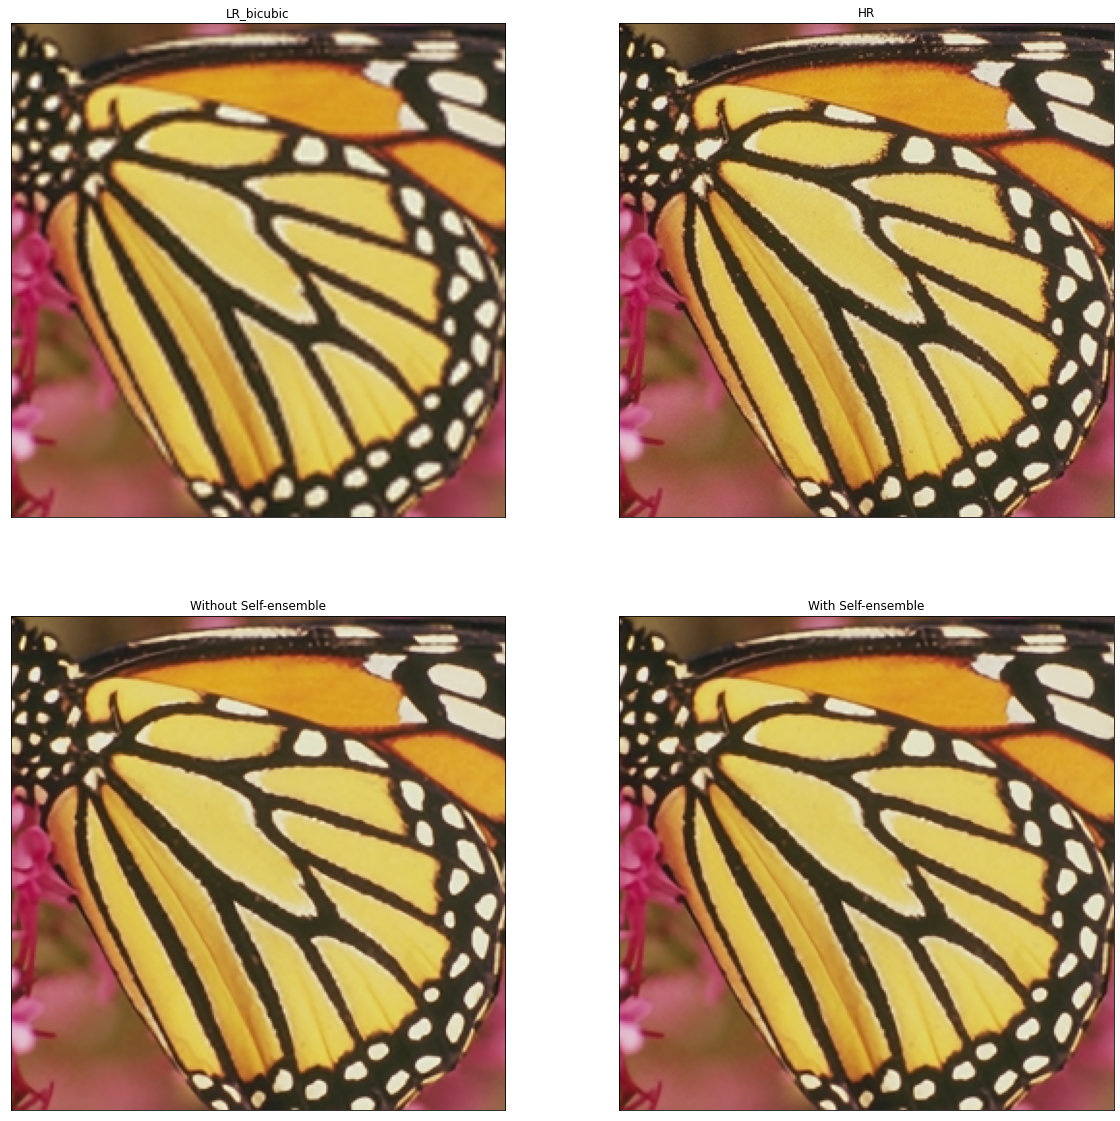

In [9]:
import os
import matplotlib.pyplot as plt

from PIL import Image

from google.colab.patches import cv2_imshow
import cv2
%matplotlib inline

def load_image(path):
    return np.array(Image.open(path))

def bicubic_image(path):
  tmp = Image.open(path)
  return np.array(tmp.resize([tmp.size[0]*2, tmp.size[1]*2], Image.BICUBIC))

def resolve_and_plot(model_pre_trained, lr_image_path, hr_image_path):
    lr = load_image(lr_image_path)
    hr = load_image(hr_image_path)
    sr = predictImg(model_pre_trained, lr)
    sr_se = predictImgSelfEnsemble(model_pre_trained, tf.expand_dims(lr, axis=0))
    lr_bicubic = bicubic_image(lr_image_path)
    plt.figure(figsize=(20, 20))
    
    model_name = model_pre_trained.name.upper()
    images = [lr_bicubic, hr, sr, sr_se]
    titles = ['LR_bicubic', 'HR', f'Without Self-ensemble', f'With Self-ensemble']
    positions = [1, 2, 3, 4]
    
    # save images
    # im = Image.fromarray(np.array(sr))
    # im.save(f'{lr_image_path[-8:-4]}SR.png')
    # im = Image.fromarray(np.array(sr_se))
    # im.save(f'{lr_image_path[-8:-4]}SRSE.png')
    
    for i, (image, title, position) in enumerate(zip(images, titles, positions)):
      plt.subplot(2, 2, position)
      plt.imshow(image)
      plt.title(title)
      plt.xticks([])
      plt.yticks([])
        

resolve_and_plot(edsrPreTrained, '/content/butterflyx2.png', '/content/butterfly.png')